<H1>
Mean Variance Portfolio Optimization


<p><b>Modern portfolio theory</b> (MPT), is a theory of finance that attempts to maximize expected return at a given amount of portfolio risk, or equivalently, minimize risk for a given level of expected return.

paradigm, given a portfolio of $n$ assets, the expected portfolio returns can be computed via

\begin{eqnarray*} \mu_p &=& \mathbf{E}\left(\sum_{i=1}^{n} w_i r_i \right) \\ &=& \sum_{i=1}^{n} w_i \mathbf{E}\left( r_i \right) \\ &=& \sum_{i=1}^{n} w_i \mu_i \\ &=& w^T \mu \end{eqnarray*}
<p>
where $w_i$ and $r_i$ are the weight and expected return of the $i^{th}$ asset.


<p>
The <b>covariance</b> matrix of the portfolio is defined as follows.
<p>
\begin{eqnarray*} \Sigma = \begin{bmatrix} \sigma_{1}^2 \ \sigma_{12} \ \dots \ \sigma_{1I} \\ \sigma_{21} \ \sigma_{2}^2 \ \dots \ \sigma_{2I} \\ \vdots \ \vdots \ \ddots \ \vdots \\ \sigma_{I1} \ \sigma_{I2} \ \dots \ \sigma_{I}^2 \end{bmatrix} \end{eqnarray*}
<br>
Where, $\sigma_{ij} = \sigma_{ji} = E\left(\left(r_i-\mu_i\right)\left(r_j-\mu_j\right)\right)$.

Given the covariance matrix, the portfolio variance is then given below.
<p>
$$ \begin{eqnarray*} \sigma_p^2 &=& \mathbf{E}\left( (r - \mu )^2 \right) \\ &=& \sum_{i=1}^{n}\sum_{i=1}^{n} w_i w_j \sigma_{ij} \\ &=& w^T \Sigma w \end{eqnarray*} $$

<p>
In order to implement a mean variance portfolio in Python, we will need some data. We will use adjusted close price data from yahoo, Quantopian's open source library, zipline, makes this a simple task.

In [5]:
#!pip install zipline
import numpy as np
import pandas as pd
from zipline.utils.factory import load_bars_from_yahoo

start = pd.Timestamp('2010-01-01', tz='utc')
end = pd.Timestamp.now().tz_localize('utc')

symbols = ['AAPL', 'GOOGL', 'MSFT', 'DB', 'GLD']
data = load_bars_from_yahoo(stocks=symbols, start=start, end=end)
data

AAPL
GOOGL
MSFT
DB
GLD


<class 'pandas.core.panel.Panel'>
Dimensions: 5 (items) x 1485 (major_axis) x 6 (minor_axis)
Items axis: AAPL to GLD
Major_axis axis: 2010-01-04 00:00:00+00:00 to 2015-11-24 00:00:00+00:00
Minor_axis axis: open to price

Populating the interactive namespace from numpy and matplotlib


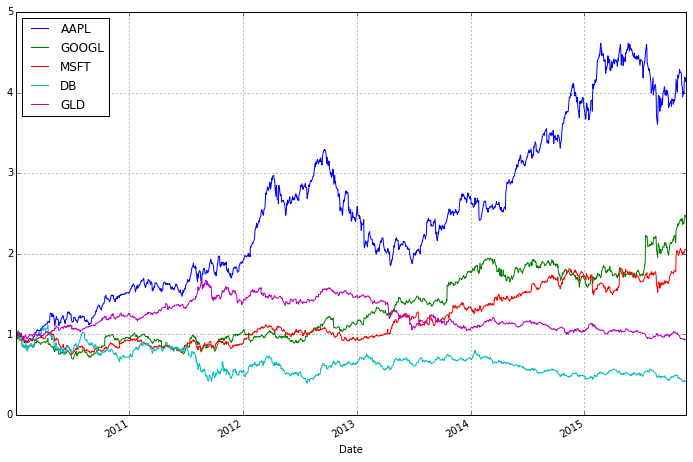

In [6]:
%pylab inline
prices = data.minor_xs('price') # Adjusted Close Prices
norm_prices = prices / prices.iloc[0]
norm_prices.plot(figsize=(12,8))

<p>
The continuously compounded return, or log return, has a few advantages over using the simple return in financial applications. A multiperiod return is the sum of the one-period returns, and the statistical properties of log returns are more tractable.

<p>
Given the simple return $R_t = (P_t - P_{t-1}) / P_{t-1}$, the log return, $r_t$, can be calculated via 
<p>
\begin{eqnarray*} r_t &=& \ln(1 + R_t)\\ &=& \ln\frac{P_t}{P_{t-1}}\\&=& \ln(P_t) - \ln(P_{t-1}) \end{eqnarray*}
<p>
With so many choices, it might be of interest to note which method can be computed the fastest.

In [7]:
# Time the methods for computing returns
%time R = np.log(1 + prices.pct_change())
%time R1 = np.log(prices / prices.shift(1))
%time R2 = np.log(prices).diff()


Wall time: 14 ms
Wall time: 2 ms
Wall time: 0 ns


In [8]:
# It looks like R2 is the fastest, before using it, we should still confirm the calculations are within machine precision
print (R - R2).abs().max()

AAPL     9.055257e-16
GOOGL    8.569534e-16
MSFT     4.996004e-16
DB       7.840950e-16
GLD      9.081277e-16
dtype: float64


In [9]:
# Use the .diff() version
rets = R2

<H4>
The Python implementations are a bit more compact than the mathematical definitions ...

In [10]:
def exp_return(weights, rets):
    return np.sum(weights * rets.mean() ) * 252

def exp_volatility(weights, rets):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

def random_weights(n):
    # Creates a normalized random vector of n weights
    weights = np.random.random(n)
    return weights / np.sum(weights)

In [11]:
%%time
n = len(symbols)
prets = []
pvols = []
for p in range (2500):
    weights = random_weights(n)
    prets.append(exp_return(weights, rets))
    pvols.append(exp_volatility(weights, rets))
prets = np.array(prets)
pvols = np.array(pvols)

Wall time: 2.75 s


<matplotlib.colorbar.Colorbar instance at 0x000000000F618B48>

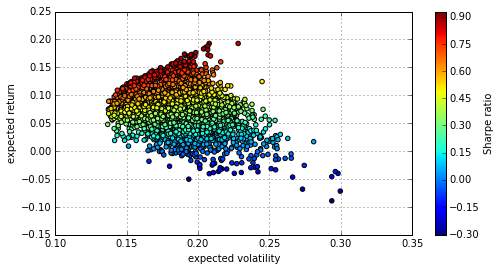

In [12]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

<h4>Let us derive the efficient frontier. First, some helper functions.

In [13]:
def statistics(weights):
    pret = exp_return(weights, rets)
    pvol = exp_volatility(weights, rets)
    return np.array([pret, pvol])

def min_portfolio_vol(weights):
    return statistics(weights)[1]

Second, the optimization procedure.

In [14]:
import scipy.optimize as sco

In [15]:
bnds = tuple((0, 1) for _ in xrange(n))
  # bounds for the asset weights

In [16]:
trets = np.linspace(0.05, 0.25, 50)
tvols = []
for tret in trets:
    constraints = (
            {'type': 'ineq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_portfolio_vol, 
                       n * [1. / n,], 
                       method='SLSQP',
                       bounds=bnds, 
                       constraints=constraints)
    tvols.append(res['fun'])
tvols = np.array(tvols)

<h4>And the efficient frontier visualized.

<matplotlib.colorbar.Colorbar instance at 0x000000000FADDB08>

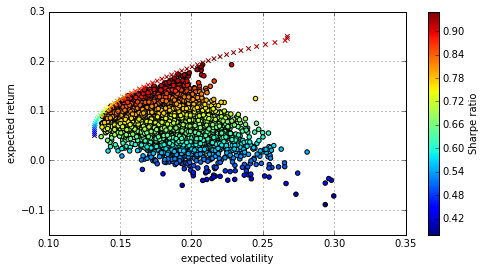

In [17]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.scatter(tvols, trets, c=trets / tvols, marker='x')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')